# Esercitazione 8: implementazione in pytorch di una rete neurale fully connected, addestrata per task di classificazione e regressione

**Dataset:** Sloan Digital Sky Survey Dataset

In [1]:
# import delle librerie
import numpy as np
import matplotlib.pyplot as plt

import pandas as pd

import torch
import torchvision  # contiene elementi per costruire la rete neurale

print(torch.__version__)
print(torchvision.__version__)

2.6.0+cu124
0.21.0+cu124


In [2]:
# download del dataset
!rm -rf star_classification.csv
!wget http://giagu.web.cern.ch/giagu/CERN/star_classification.csv

--2025-04-15 09:35:23--  http://giagu.web.cern.ch/giagu/CERN/star_classification.csv
Resolving giagu.web.cern.ch (giagu.web.cern.ch)... 188.185.18.46, 188.185.50.104, 188.185.5.88, ...
Connecting to giagu.web.cern.ch (giagu.web.cern.ch)|188.185.18.46|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://giagu.web.cern.ch/giagu/CERN/star_classification.csv [following]
--2025-04-15 09:35:24--  https://giagu.web.cern.ch/giagu/CERN/star_classification.csv
Connecting to giagu.web.cern.ch (giagu.web.cern.ch)|188.185.18.46|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16755863 (16M) [text/csv]
Saving to: ‘star_classification.csv’

star_classification 100%[===================>]  15.98M  7.70MB/s    in 2.1s    

2025-04-15 09:35:27 (7.70 MB/s) - ‘star_classification.csv’ saved [16755863/16755863]



Il dataset consiste in 100000 osservazioni dello spazio effettuate dal SDSS (Sloan Digital Sky Survey). Ogni osservazione è descritta da 17 colonne di caratteristiche e 1 colonna di classe (*'class'*) che la identifica come stella (*'STAR'*), galassia (*'GALAXY'*) o quasar (*'QSO'*)

Vogliamo allenare due reti neurali di tipo MLP (Multi Layer Perceptron), una per predire la classe a partire dalle 11 colonne (*'alpha', 'delta', 'u', 'g', 'r', 'i', 'z', 'cam_col', 'redshift', 'plate', 'MJD'*) (classificazione), e una per predire il target *'redshift'* a partire dalle 10 colonne (*'alpha', 'delta', 'u', 'g', 'r', 'i', 'z', 'cam_col', 'plate', 'MJD'*) (regressione).

Contenuto delle colonne del dataset:

1. obj_ID = Object Identifier, the unique value that identifies the object in the image catalog used by the CAS
2. alpha = Right Ascension angle (at J2000 epoch)
3. delta = Declination angle (at J2000 epoch)
4. u = Ultraviolet filter in the photometric system
5. g = Green filter in the photometric system
6. r = Red filter in the photometric system
7. i = Near Infrared filter in the photometric system
8. z = Infrared filter in the photometric system
9. run_ID = Run Number used to identify the specific scan
10. rereun_ID = Rerun Number to specify how the image was processed
11. cam_col = Camera column to identify the scanline within the run
12. field_ID = Field number to identify each field
13. spec_obj_ID = Unique ID used for optical spectroscopic objects (this means that 2 different observations with the same spec_obj_ID must share the output class)
14. class = object class (galaxy, star or quasar object)
15. redshift = redshift value based on the increase in wavelength
16. plate = plate ID, identifies each plate in SDSS
17. MJD = Modified Julian Date, used to indicate when a given piece of SDSS data was taken
18. fiber_ID = fiber ID that identifies the fiber that pointed the light at the focal plane in each observation


In [3]:
# importa in un dataframe pandas il dataset
df = pd.read_csv('star_classification.csv')
display(df)

# attenzione: class è una stringa e non un float

,obj_ID,alpha,delta,u,g,r,i,z,run_ID,rerun_ID,cam_col,field_ID,spec_obj_ID,class,redshift,plate,MJD,fiber_ID
0,1.237661e+18,135.689107,32.494632,23.87882,22.27530,20.39501,19.16573,18.79371,3606,301,2,79,6.543777e+18,GALAXY,0.634794,5812,56354,171
1,1.237665e+18,144.826101,31.274185,24.77759,22.83188,22.58444,21.16812,21.61427,4518,301,5,119,1.176014e+19,GALAXY,0.779136,10445,58158,427
2,1.237661e+18,142.188790,35.582444,25.26307,22.66389,20.60976,19.34857,18.94827,3606,301,2,120,5.152200e+18,GALAXY,0.644195,4576,55592,299
3,1.237663e+18,338.741038,-0.402828,22.13682,23.77656,21.61162,20.50454,19.25010,4192,301,3,214,1.030107e+19,GALAXY,0.932346,9149,58039,775
4,1.237680e+18,345.282593,21.183866,19.43718,17.58028,16.49747,15.97711,15.54461,8102,301,3,137,6.891865e+18,GALAXY,0.116123,6121,56187,842
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,1.237679e+18,39.620709,-2.594074,22.16759,22.97586,21.90404,21.30548,20.73569,7778,301,2,581,1.055431e+19,GALAXY,0.000000,9374,57749,438
99996,1.237679e+18,29.493819,19.798874,22.69118,22.38628,20.45003,19.75759,19.41526,7917,301,1,289,8.586351e+18,GALAXY,0.404895,7626,56934,866
99997,1.237668e+18,224.587407,15.700707,21.16916,19.26997,18.20428,17.69034,17.35221,5314,301,4,308,3.112008e+18,GALAXY,0.143366,2764,54535,74
99998,1.237661e+18,212.268621,46.660365,25.35039,21.63757,19.91386,19.07254,18.62482,3650,301,4,131,7.601080e+18,GALAXY,0.455040,6751,56368,470


In [4]:
# stampa il numero di esempi in cascuna classe (GALAXY, STAR, Q (QUASAR)), vedo se le classi sono bilanciate (in questo caso non lo sono)
display(df['class'].value_counts())  # quanti per ciascuna classe
df['class'].value_counts(normalize=True).to_frame().style.bar(color='green')  # semplice istogramma con frequenze relative (normalizzato)

,count
class,
GALAXY,59445
STAR,21594
QSO,18961


,proportion
class,
GALAXY,0.594450
STAR,0.215940
QSO,0.189610


In [5]:
# problema: l'indice di classe è una str e non un intero come vorrebbe PyTorch, quindi devo trasformare le str in un indice intero

In [6]:
# trasforma label da string a indice numerico intero (0,1,2)
from sklearn import preprocessing
LE = preprocessing.LabelEncoder()
df['class'] = LE.fit_transform(df['class'])  # trasforma le labels e corregge la colonna 'class' con i numeri interi
df['class'].value_counts()

,count
class,
0,59445
2,21594
1,18961


In [7]:
# bilancio le classi per la classificazione, conveniente per una buona risposta della rete neurale
# posso fare downsampling riducendo la classe galaxy con selezione random (classe maggioritaria)
# posso fare upsampling (sconsigliato) prendendo QSO, ricampionando la classe stessa (duplicazione degli eventi, comporta bias, non aumenta il potere statistico della classe minoritaria)
# SCELTA MIGLIORE: uso dei pesi opportuni per il calcolo della loss

In [8]:
# calcola pesi per ribilanciare le classi (da usare con la loss BinaryCrossEntropy (BCE))

# peso_classe_i = N_tot / (N_classi * N_i) con N_tot #totale_eventi,  N_classi #classi,  N_i #eventi_nella_classe_i-esima
# sono pesi inversamente proporzionali alla frequenza della classe

cls_w = []
allev = sum(df['class'].value_counts())
for i in range(3):
  cls_w.append(allev/(3*df['class'].value_counts()[i]))
print(cls_w)

# nell'output i pesi sono [classe 0, classe 1, classe 2]

[np.float64(0.5607424229680097), np.float64(1.757994479897333), np.float64(1.5436386650612826)]


In [9]:
# Seleziono solo le variabili utili

# per il task di classificazione usiamo come feature 'alpha', 'delta', 'u', 'g', 'r', 'i', 'z', 'redshift' - e come label "class"
x_cls = df.drop(['obj_ID', 'run_ID', 'rerun_ID', 'cam_col', 'field_ID', 'spec_obj_ID', 'class', 'plate', 'MJD', 'fiber_ID'], axis = 1).values
y_cls = df['class'].values
# il metodo .drop elimina le colonne selezionate

# per il task di regressione usiamo come feature 'alpha', 'delta', 'u', 'g', 'r', 'z'  - e come target una funzione non lineare di tali misure (solo per scopi didattici)
x_reg = df.drop(['obj_ID', 'run_ID', 'rerun_ID', 'cam_col', 'field_ID', 'spec_obj_ID', 'class', 'i', 'redshift', 'plate', 'MJD', 'fiber_ID'], axis = 1).values
y_reg = 10 * np.sin(np.pi * x_reg[:,0] * x_reg[:,1]) + 20 * (x_reg[:,2] - 0.5) ** 2 + 10 * x_reg[:,3] + 5 * x_reg[:,4] + 2*x_reg[:,5]

# eliminiamo valori troppo grandi generati dalla funzione scelta che potrebbero rendere instabile il training:
x_reg = x_reg[y_reg<20000]
y_reg = y_reg[y_reg<20000]
y_reg = y_reg.reshape((-1,1))

print(x_cls.shape)
print(y_cls.shape)
print(x_reg.shape)
print(y_reg.shape)

(100000, 8)
(100000,)
(99998, 6)
(99998, 1)


In [10]:
# Preprocessamento del dataset
# divisione in train, validation e test dataset (33:33:33)
from sklearn.model_selection import train_test_split

x_cls_train,x_cls_test,y_cls_train,y_cls_test = train_test_split(x_cls , y_cls , test_size=0.33, shuffle=True, random_state=0)
x_cls_train,x_cls_vali,y_cls_train,y_cls_vali = train_test_split(x_cls_train , y_cls_train , test_size=0.5, shuffle=True, random_state=0)
print(x_cls_train.shape)
print(x_cls_vali.shape)
print(x_cls_test.shape)

x_reg_train,x_reg_test,y_reg_train,y_reg_test = train_test_split(x_reg , y_reg , test_size=0.33, shuffle=True, random_state=0)
x_reg_train,x_reg_vali,y_reg_train,y_reg_vali = train_test_split(x_reg_train , y_reg_train , test_size=0.5, shuffle=True, random_state=0)
print(x_reg_train.shape)
print(x_reg_vali.shape)
print(x_reg_test.shape)

(33500, 8)
(33500, 8)
(33000, 8)
(33499, 6)
(33499, 6)
(33000, 6)


**Normalizzazione delle fetaure in input**: normalizzare l'input permette di usare learnign rate più grandi (e quindi effetturare un training più veloce) oltre a stabilizzare l'addestramento ...

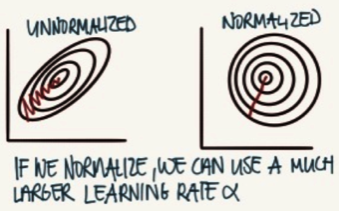

In [11]:
# normalizzazione (x-mu)/sdev

# per evitare possibile passaggio di informazione dal dataset di test in quello di training è preferibile normalizzare tutti i dataset
# o usando i parametri del solo training dataset, oppure indipendentemente uno dall'altro

# normalizzaiamo i dataset indipendentemente uno dall'altro (buona alternativa all'altro metodo che conosciamo)
# StandardScaler: z = (x-media)/std
sc_cls_train = preprocessing.StandardScaler()
sc_cls_vali = preprocessing.StandardScaler()
sc_cls_test = preprocessing.StandardScaler()

x_cls_train = sc_cls_train.fit_transform(x_cls_train)
x_cls_vali = sc_cls_vali.fit_transform(x_cls_vali)
x_cls_test = sc_cls_test.fit_transform(x_cls_test)


sc_reg_train = preprocessing.StandardScaler()
sc_reg_vali = preprocessing.StandardScaler()
sc_reg_test = preprocessing.StandardScaler()


x_reg_train = sc_reg_train.fit_transform(x_reg_train)
x_reg_vali = sc_reg_vali.fit_transform(x_reg_vali)
x_reg_test = sc_reg_test.fit_transform(x_reg_test)


# per la task di regressione per la funzione scelta il range di variazione del target è molto ampio e questo può
# rendere instabile il training. Conviene noralizzare il target tra -1 e 1

y_reg_train = 2*y_reg_train - np.min(y_reg_train)/(np.max(y_reg_train)-np.min(y_reg_train))-1.0
y_reg_vali = 2*y_reg_vali - np.min(y_reg_vali)/(np.max(y_reg_vali)-np.min(y_reg_vali))-1.0
y_reg_test = 2*y_reg_test - np.min(y_reg_test)/(np.max(y_reg_test)-np.min(y_reg_test))-1.0

In [12]:
# conversione in tensori torch dei vettori numpy

# per la classificazione la label deve essere long int
x_cls_train_pt = torch.Tensor(x_cls_train).float()
y_cls_train_pt = torch.Tensor(y_cls_train).long()  # cuda vuole long int per le label
x_cls_vali_pt = torch.Tensor(x_cls_vali).float()
y_cls_vali_pt = torch.Tensor(y_cls_vali).long()
x_cls_test_pt = torch.Tensor(x_cls_test).float()
y_cls_test_pt = torch.Tensor(y_cls_test).long()

print(x_cls_train_pt.shape)
print(y_cls_train_pt.shape)
print(x_cls_vali_pt.shape)
print(y_cls_vali_pt.shape)
print(x_cls_test_pt.shape)
print(y_cls_test_pt.shape)

# per la regressione vanno bene tutti float
x_reg_train_pt = torch.Tensor(x_reg_train).float()
y_reg_train_pt = torch.Tensor(y_reg_train).float()
x_reg_vali_pt = torch.Tensor(x_reg_vali).float()
y_reg_vali_pt = torch.Tensor(y_reg_vali).float()
x_reg_test_pt = torch.Tensor(x_reg_test).float()
y_reg_test_pt = torch.Tensor(y_reg_test).float()


print(x_reg_train_pt.shape)
print(y_reg_train_pt.shape)
print(x_reg_vali_pt.shape)
print(y_reg_vali_pt.shape)
print(x_reg_test_pt.shape)
print(y_reg_test_pt.shape)

torch.Size([33500, 8])
torch.Size([33500])
torch.Size([33500, 8])
torch.Size([33500])
torch.Size([33000, 8])
torch.Size([33000])
torch.Size([33499, 6])
torch.Size([33499, 1])
torch.Size([33499, 6])
torch.Size([33499, 1])
torch.Size([33000, 6])
torch.Size([33000, 1])


Uso della GPU. Se si ha a disposizione una GPU può essere utilizzata per accelerare le operazioni. Questo richiede di spostare i tensori e il modello di rete neurale sulla GPU quando si effettuano i calcoli. È conveniente controllare se la GPU è disponibile e nel caso settare una variabile opportuna per l'uso successivo.

In [13]:
# controlliamo se la GPU è disponibile e nel caso quale tipo di GPU
import torch
if torch.cuda.is_available():
  print('Numero di GPU disponibili: ',torch.cuda.device_count())
  for i in range(0,torch.cuda.device_count()):
    print(torch.cuda.get_device_name(i))

# se la GPU è disponibile setto device='cuda', altrimenti 'cpu'
device = ('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Computation device: {device}\n")

Numero di GPU disponibili:  1
Tesla T4
Computation device: cuda



In [15]:
# per allenare la rete neurale con SGD (stochastic gradient descent), dobbiamo dividere
# il campione di training in mini batch (blocchetti, guarda sotto per capire perché), e eventualmente fare un reshuffling degli eventi ad ogni epoca,
# applicare trasformazioni etc...

# questo viene fatto in pytorch automaticamente tramite delle helper functions chiamate
# Datasets e DataLoaders

# pytorch dataset: premette di accoppiare feature e target per ogni evento e di accedere ad ogni coppia del
# dataset; mette insieme features e target

# pytorch dataloader: permette di costruire un iterabile python e applicare divisione in mini-batch, shuffling,
# uso di multiprocessing per leggere i dati, applicare data augmentation, etc.... In pratica ricotruisce il dataset

from torch.utils.data import TensorDataset, DataLoader

batch = 128

# dataset per classificazione
ds_cls_train = TensorDataset(x_cls_train_pt, y_cls_train_pt)
dl_cls_train = DataLoader(ds_cls_train, batch_size=batch, shuffle=True, num_workers=1, drop_last=True)
# num_workers influisce sulla velocità del processo: per saperne di più guarda sotto!

ds_cls_vali = TensorDataset(x_cls_vali_pt, y_cls_vali_pt)
dl_cls_vali = DataLoader(ds_cls_vali, batch_size=batch, shuffle=True, num_workers=1, drop_last=True)

ds_cls_test = TensorDataset(x_cls_test_pt, y_cls_test_pt)
dl_cls_test = DataLoader(ds_cls_test, batch_size=batch, shuffle=True, num_workers=1, drop_last=True)

# dataset per regressione
ds_reg_train = TensorDataset(x_reg_train_pt, y_reg_train_pt)
dl_reg_train = DataLoader(ds_reg_train, batch_size=batch, shuffle=True, num_workers=1, drop_last=True)

ds_reg_vali = TensorDataset(x_reg_vali_pt, y_reg_vali_pt)
dl_reg_vali = DataLoader(ds_reg_vali, batch_size=batch, shuffle=True, num_workers=1, drop_last=True)

ds_reg_test = TensorDataset(x_reg_test_pt, y_reg_test_pt)
dl_reg_test = DataLoader(ds_reg_test, batch_size=batch, shuffle=True, num_workers=1, drop_last=True)

**Per quale motivo devo dividere il campione in batch?**

Offre diversi vantaggi rispetto all'addestramento su tutto il dataset in un'unica operazione (batch completo) o su un singolo campione alla volta (stochastic gradient descent).
- Gradienti Più Stabili: Utilizzare un mini-batch fornisce una stima più stabile e meno rumorosa del gradiente rispetto all'uso di un singolo campione (come avviene nello stochastic gradient descent).
- Aggiornamenti Frequenti: Rispetto all'utilizzo dell'intero dataset, l'aggiornamento dei pesi del modello avviene più frequentemente, permettendo al modello di adattarsi più rapidamente alle caratteristiche dei dati.
- Varietà nei Batch: Mini-batch mescolati offrono una migliore rappresentazione della distribuzione del dataset, riducendo il rischio di overfitting rispetto all'uso di batch interi o singoli campioni in sequenza.
- Riduzione dell'Overfitting: Frequenti aggiornamenti dei pesi con batch differenti possono agire come una forma di regolarizzazione, aiutando a prevenire il sovradattamento ai dati di addestramento.
- Aggiornamenti Incrementali: L'uso di mini-batch consente di aggiornare i pesi del modello più frequentemente che non usando l'intero dataset, portando spesso a una convergenza più rapida verso un minimo della funzione di costo.

**parametro num_workers di DataLoader**

Specifica il numero di subprocessi utilizzati per il caricamento dei dati.
- *num_workers=0* : Il caricamento dei dati avviene nel thread principale del programma. Questo può essere lento, soprattutto se il dataset è grande, perché il caricamento dei dati e l'allenamento del modello competono per le risorse della CPU. Infatti significa che tutte le operazioni di caricamento e pre-elaborazione dei dati vengono eseguite nel medesimo thread che esegue anche l'allenamento del modello.
- *num_workers=1* : Un singolo processo separato viene utilizzato per il caricamento dei dati. Questo può migliorare le prestazioni rispetto a num_workers=0, perché il caricamento dei dati può avvenire in parallelo rispetto all'allenamento del modello.
- *num_workers>1* : Più subprocessi vengono utilizzati per il caricamento dei dati in parallelo. Questo può accelerare ulteriormente il caricamento, soprattutto se i dati richiedono pre-elaborazione complessa o se il dataset è molto grande.

In [16]:
# ogni data loader fornisce un iteratore con il quale si possono accedere ai vari mini-batch del dataset

feat, label = next(iter(dl_cls_train))

print(f"Feature batch shape: {feat.size()}")
print(f"Labels batch shape: {label.size()}")

# quello che sto facendo qui:
# iter(dl_cls_train): La funzione iter() viene chiamata sull'oggetto dl_cls_train, creando un iteratore per il data loader. Questo iteratore permette di scorrere sequenzialmente sui dati del dataset.
# next(iter(dl_cls_train)): La funzione next() viene chiamata sull'iteratore ottenuto. next() restituisce il prossimo elemento dall'iteratore. Nel contesto dei data loader, ogni elemento è generalmente una tupla contenente un batch di caratteristiche (features) e le relative etichette (labels).
# feat, label = next(iter(dl_cls_train)): Il risultato della chiamata a next() viene decomposto in due variabili, feat e label. Qui, feat rappresenta il batch di caratteristiche e label rappresenta il batch di etichette corrispondenti.

Feature batch shape: torch.Size([128, 8])
Labels batch shape: torch.Size([128])


### Definzione del modello di rete neurale per la classificazione.

Archiettura: MLP con layer densi (Linear in pytorch):
 con 2 layer hidden con attivazioni ReLU, e 3 neuroni di output con attivazione softmax che predicono la probabilità che l'input appartenga ad una delle 3 classi possibili:

*   input layer: 8 neuroni (la dimensione del vettore di input x)
*   primo hidden layer: 128 neuroni, attivazione ReLU
*   secondo hidden layer: 128 neuroni, attivazione ReLU
*   output layer: 3 neuroni, attivazione softmax

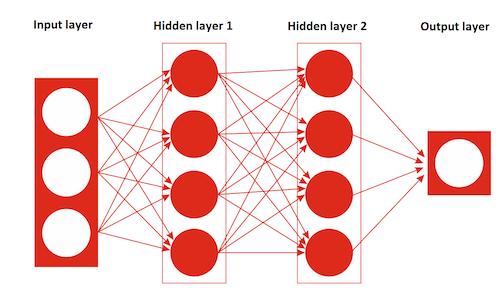

In [18]:
from torch import nn
import torch.nn.functional as F  # Questo modulo contiene molte funzioni utili per creare e modificare reti neurali, comprese funzioni di attivazione, funzioni di perdita

# in pytorch una rete neurale viene implementata costruendo una classe python che eredita
# dalla classe di pytorch nn.Module e implementa due metodi di base:
# __init__: definizione dei layer utlizzati
# forward: funzione che calcola y = ANN(x), deve essere definito all'interno della classe per specificare come i dati vengono elaborati attraverso la rete.

class ShallowMLP(nn.Module):
  def __init__(self, input_dim=8, output_dim=3, hidden_dim=128):
    super(ShallowMLP, self).__init__()  # Questa riga chiama il metodo di inizializzazione della classe genitore nn.Module. È importante chiamare questo metodo per inizializzare correttamente la classe base.

    # inizializzazione dei layer/funzioni che utilizzeremo per definire la rete

    #torch.nn.Linear(in_features, out_features, bias=True, device=None, dtype=None)
    self.layer1 = nn.Linear(input_dim, hidden_dim)  # hidden layer
    self.layer2 = nn.Linear(hidden_dim, hidden_dim)  # questo secondo hidden layer prende l'output del precedente
    self.layer3 = nn.Linear(hidden_dim, output_dim) # output layer
    # ho specificato per ogni layer quanti dati prende e quanti ne restituisce

    self.relu = nn.ReLU() # relu function (NOTA: non è obbligatorio definirla qui, è anche possible usare la forma funzionale F.relu() direttamente nel metodo forward())

  def forward(self, x):
    x = self.layer1(x)
    x = self.relu(x) # oppure x = F.relu(x)
    x = self.layer2(x)
    x = self.relu(x)
    out = self.layer3(x)
    # NOTA: non applichiamo softmax perché la loss nn.CrossEntropyLoss() già lo applica automaticamente al suo interno
    return out

In [20]:
# stampa del modello

model = ShallowMLP(input_dim=8, output_dim=3)  # definizione del modello
print(model)

from torchsummary import summary
if torch.cuda.is_available():  # ovvero se è disponibile la GPU
  summary(model.cuda(), input_size=(1,8))
else:
  summary(model, input_size=(1,8))

ShallowMLP(
  (layer1): Linear(in_features=8, out_features=128, bias=True)
  (layer2): Linear(in_features=128, out_features=128, bias=True)
  (layer3): Linear(in_features=128, out_features=3, bias=True)
  (relu): ReLU()
)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1               [-1, 1, 128]           1,152
              ReLU-2               [-1, 1, 128]               0
            Linear-3               [-1, 1, 128]          16,512
              ReLU-4               [-1, 1, 128]               0
            Linear-5                 [-1, 1, 3]             387
Total params: 18,051
Trainable params: 18,051
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.07
Estimated Total Size (MB): 0.07
----------------------------------------------------------------


In [21]:
# testiamo un batch del dataset di train sul modello non addestrato per vedere che le cose funzionino
# è sempre una buona idea farlo prima di passare al vero e proprio train!

feat, label = next(iter(dl_cls_train))

feat=feat.to(device)  # sposto sulla GPU il batch di dati
label=label.to(device)  # sposto sulla GPU il batch di label
# faccio questo spostamento perché:
# è comune sfruttare l'accelerazione hardware delle GPU per migliorare
# significativamente la velocità di addestramento e inferenza del modello.
# Tuttavia, i tensori (come features e labels) devono essere esplicitamente
# spostati sulla GPU affinché possano essere utilizzati lì.

# Posso anche spostare sulla CPU se non voglio utilizzare la GPU

model.to(device)  # sposto il modello sulla GPU
out = model(feat)  # applico il modello agli eventi del batch

print('input della rete neurale: ', feat.shape)
print('output della rete neurale: ', out.shape)
print(out[0])  # nota questi sono i logit di output (eg. non c'è softmax applicato, perché questo viene applicato dentro la loss-function nn.CrossEntropyLoss() )

# output softmax:

print(F.softmax(out, dim=1)[0])  # np.exp(out[0][i]) / (np.exp(out[0][0]) + np.exp(out[0][1]) + np.exp(out[0][2]))

input della rete neurale:  torch.Size([128, 8])
output della rete neurale:  torch.Size([128, 3])
tensor([-0.0431,  0.0031, -0.3011], device='cuda:0', grad_fn=<SelectBackward0>)
tensor([0.3546, 0.3714, 0.2740], device='cuda:0', grad_fn=<SelectBackward0>)


**LOGIT**

Dati grezzi prodotti dalla rete neurale.
Ad esempio, se stai facendo classificazione, i logit di output rappresentano i punteggi associati a ciascuna classe possibile. Tuttavia, questi punteggi non sono ancora probabilità perché non sono stati normalizzati e non sono stati sottoposti a una trasformazione come la funzione softmax.
Dopo che i logit sono stati calcolati, di solito vengono passati attraverso una funzione di attivazione, come la funzione softmax, che converte i punteggi in probabilità, rendendo più facile interpretare l'output come una distribuzione di probabilità sui vari possibili risultati.

Quindi quello che sto facendo sopra è:
- print(out[0]) : stampa l'output grezzo (logit), che come vedo può contenere anche numeri negativi, non interpretabili come probabilità;
- print(F.softmax(out, dim=1)[0]) : stampa lo stesso output ma dopo averlo trasformato con softmax, adesso posso interpretarlo come probabilità (somma totale = 1.0)

In [22]:
# Per completare il modello dobbiamo definire la loss function, le eventuali metriche per monitorare il
# training della rete, e infine l'ottimizzatore

# per il task di classificazione la loss standard è la BCE
loss_fun = nn.CrossEntropyLoss()

# ottimizzatore: uso per esempio Adam (SGD adattivo)
from torch import optim
lr = 0.001  # learning rate iniziale (arbitrario)
opt = optim.Adam(model.parameters(), lr=lr)

In [23]:
#install torchmetrics: collection of useful PyTorch metrics implementations and an easy-to-use API to create custom metrics
%pip install torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 961.5/961.5 kB 23.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 114.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 86.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 56.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 80.5 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstal

In [24]:
# metrica per monitorare il training: accuracy (multiclasse)

import torchmetrics
from torchmetrics.classification import Accuracy

metric_fun = Accuracy(task="multiclass", num_classes=3)
metric_fun = metric_fun.to(device)  # NOTA: va spostata anche essa nel device in cui si esegue il calcolo e sono presenti i tensori (non necessario per le loss std di pytorch)

In [25]:
# Ridefinizione del modello, per sicurezza

model = ShallowMLP(input_dim=8, output_dim=3)
lr = 0.001
opt = optim.Adam(model.parameters(), lr=lr)

# vogliamo usare la GPU quindi spostiamo il modello sulla GPU
model.to(device)

ShallowMLP(
  (layer1): Linear(in_features=8, out_features=128, bias=True)
  (layer2): Linear(in_features=128, out_features=128, bias=True)
  (layer3): Linear(in_features=128, out_features=3, bias=True)
  (relu): ReLU()
)

In [26]:
# in pytorch è necessario scriversi il loop di training, cioè il loop sulle epoch di training in cui in ogni
# epoca si leggono tutti gli eventi del dataset aggiornando i pesi dopo ogni mini-batch
import time

def train_model(nn_model, criterion, metric, n_epochs, dl_train, dl_vali):

  # liste su cui salvare il valore della loss e della metrica ad ogni epoca per poterli graficare in funzione dell'epoca a fine addestramento
  hist_loss = []
  hist_metric = []
  hist_vloss = []
  hist_vmetric = []

  # loop sulle epoche
  for epoch in range(n_epochs):
    t0 = time.time()

    # training step (in cui aggiorniamo i pesi della rete neurale)
    model.train()
    train_loss = 0
    train_metric = 0
    acc_tmp = 0
    counter = 0
    for xb, yb in dl_train:
        counter += 1
        xb=xb.to(device)
        yb=yb.to(device)

        pred = nn_model(xb)  # predizione del modello

        # calcolo loss e metrica
        loss = criterion(pred, yb)
        if metric != None:
          tmetric = metric(pred, yb)

          # calcolo accuracy a mano (se non si vuole usare trochmetrics)
          pred_class = torch.argmax(pred, 1)
          acc_tmp += (torch.sum(pred_class == yb).float() / yb.nelement())

        # aggiorno la loss e metrica totale
        train_loss += loss.item()
        if metric != None:
          train_metric += tmetric.item()

        # backpropagation
        opt.zero_grad()  # resetta i gradienti prima di eseguire la backpropagation (importante!)
        loss.backward()  # calcola i gradienti della loss
        opt.step()  # aggiorna i pesi


    train_loss /= counter
    hist_loss.append(train_loss)

    if metric != None:
      train_metric /= counter
      acc_tmp /= counter
      hist_metric.append(train_metric)


    # validation step (non vengono aggiornati i pesi)
    model.eval()
    vali_loss = 0
    vali_metric = 0
    counter = 0
    with torch.no_grad():  # evita che vengano cacolati automaticamente i gradienti
      for xb, yb in dl_vali:
        counter += 1
        xb=xb.to(device)
        yb=yb.to(device)

        pred = nn_model(xb)  # predizione del modello

        # calcolo loss e metrica
        vloss = criterion(pred, yb)
        vali_loss += vloss.item()

        if metric != None:
          vmetric = metric(pred, yb)
          vali_metric += vmetric.item()

    vali_loss /= counter
    hist_vloss.append(vali_loss)

    if metric != None:
      vali_metric /= counter
      hist_vmetric.append(vali_metric)

    elapsed_time = time.time()-t0
    if metric != None:
      print("epoch: %d, time(s): %.4f, train loss: %.6f, train metric: %.6f, vali loss: %.6f, vali metric: %.6f, train accuracy (manual): %.6f"
            % (epoch+1, elapsed_time, train_loss, train_metric, vali_loss, vali_metric, acc_tmp))
    else:
      print("epoch: %d, time(s): %.4f, train loss: %.6f, vali loss: %.6f"
            % (epoch+1, elapsed_time, train_loss, vali_loss))

  return nn_model, hist_loss, hist_metric, hist_vloss, hist_vmetric

In [27]:
# numero di epoche e chiamata della funzione
epochs = 30
model, hist_loss, hist_metric, hist_vloss, hist_vmetric = train_model(nn_model=model, criterion=loss_fun, metric=metric_fun, n_epochs=epochs, dl_train=dl_cls_train, dl_vali=dl_cls_vali)

epoch: 1, time(s): 2.6882, train loss: 0.338695, train metric: 0.873084, vali loss: 0.200555, vali metric: 0.929568, train accuracy (manual): 0.873084
epoch: 2, time(s): 4.1883, train loss: 0.171070, train metric: 0.945672, vali loss: 0.153791, vali metric: 0.955699, train accuracy (manual): 0.945672
epoch: 3, time(s): 2.0787, train loss: 0.146039, train metric: 0.956418, vali loss: 0.146352, vali metric: 0.957046, train accuracy (manual): 0.956418
epoch: 4, time(s): 2.0766, train loss: 0.135732, train metric: 0.959710, vali loss: 0.136045, vali metric: 0.961446, train accuracy (manual): 0.959710
epoch: 5, time(s): 2.0694, train loss: 0.129242, train metric: 0.960399, vali loss: 0.129795, vali metric: 0.960219, train accuracy (manual): 0.960399
epoch: 6, time(s): 2.2673, train loss: 0.123046, train metric: 0.962404, vali loss: 0.124997, vali metric: 0.963153, train accuracy (manual): 0.962404
epoch: 7, time(s): 2.5495, train loss: 0.120944, train metric: 0.962255, vali loss: 0.124303, 

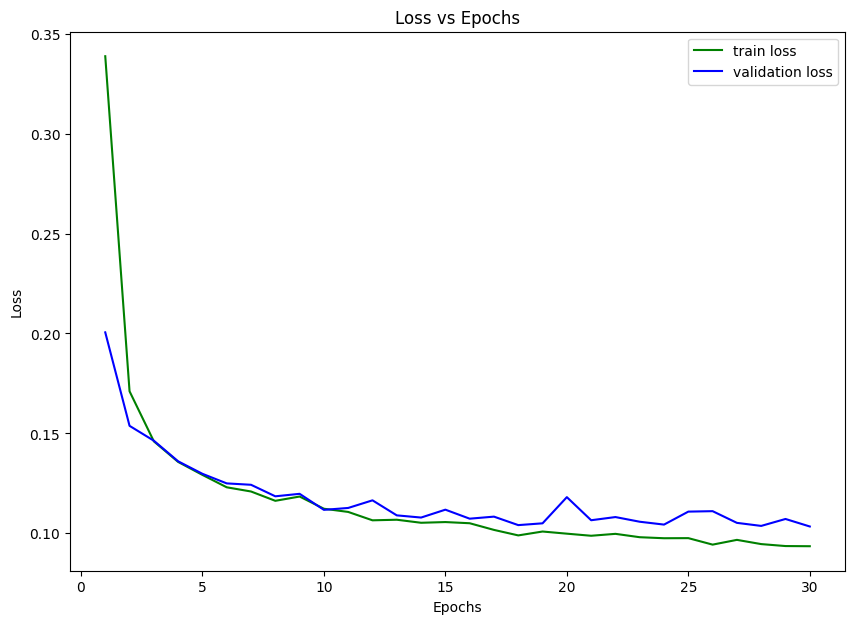

In [28]:
# grafico loss in funzione delle epoche
plt.figure(figsize=(10, 7))
plt.plot(range(1,len(hist_loss)+1), hist_loss, color='green', linestyle='-', label='train loss')
plt.plot(range(1,len(hist_vloss)+1), hist_vloss, color='blue', linestyle='-', label='validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss vs Epochs')
plt.legend()
plt.show()

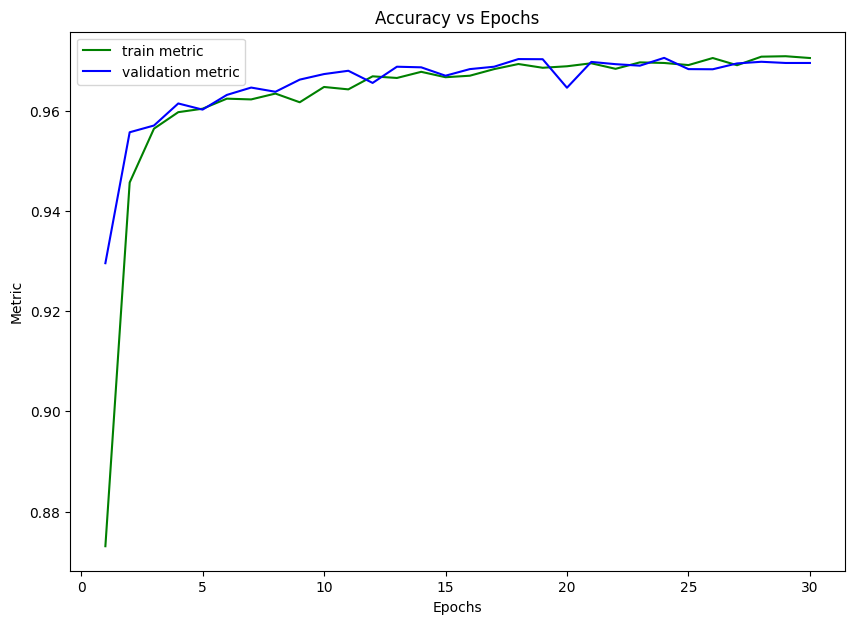

In [29]:
# grafico accuracy vs epoca
plt.figure(figsize=(10, 7))
plt.plot(range(1,len(hist_metric)+1),hist_metric, color='green', linestyle='-', label='train metric')
plt.plot(range(1,len(hist_vmetric)+1),hist_vmetric, color='blue', linestyle='-', label='validation metric')
plt.xlabel('Epochs')
plt.ylabel('Metric')
plt.title('Accuracy vs Epochs')
plt.legend()
plt.show()
# se le due curve hanno più o meno lo stesso andamento allora non c'è overfitting

In [32]:
# Salvataggio del modello, per poterlo riutilizzare senza addestrarlo di nuovo
torch.save(model, './trained_model.pt')

In [34]:
# Dopo aver addestrato il modello posso finalmente utilizzarlo per fare delle predizioni sul test set riguardo al task di classificazione

model.eval()  # va sempre fatto per settare eventuali layer di droput e batch norm in evaluation model
# model.eval() è molto IMPORTANTE, vedi sotto le note!

model.to(device)
metric_fun.to(device)

loss = 0
metric = 0
counter = 0

with torch.no_grad():  # evita che vengano cacolati automaticamente i gradienti
  for xb, yb in dl_cls_test:
    counter += 1
    xb=xb.to(device)
    yb=yb.type(torch.LongTensor).to(device)
    pred = model(xb)

    loss += loss_fun(pred, yb).item()
    metric += metric_fun(pred, yb).item()

  loss /= counter
  metric /= (counter)

print('Test loss/accuracy: ',loss, ' / ', metric)

# l'accuracy è più bassa sul test anche se ho evitato l'overfitting
# magari perché nel test set per fluttuazioni ho più dati per una classe specifica, quindi anche se ho addestrato bene sulle tre classi adesso fa difficoltà;
# quello che posso fare è costruire la matrice di confusione 3x3 e vedere davvero cosa sta succedendo (accuracy diversa per ciascuna classe)
# oppure uso una loss pesata che risolve il problema

Test loss/accuracy:  0.37870799254350623  /  0.8700449902723736


**model.eval()**

Il comando model.eval() imposta il modello in modalità di valutazione, *disattivando il dropout*, *impostando la normalizzazione batch in modalità di valutazione* e *garantendo che i parametri del modello non vengano aggiornati*. Questo è utile quando si valuta il modello su dati di test o di validazione dopo aver completato il training.

- *Disattiva il Dropout* : Durante l'addestramento, il dropout è spesso utilizzato per regolarizzare il modello, cioè per prevenire l'overfitting. Il dropout consiste nel disattivare casualmente alcuni neuroni durante l'addestramento. Quando il modello è in modalità di valutazione (model.eval()), il dropout viene disattivato, il che significa che tutti i neuroni sono attivi. Questo è importante perché durante la valutazione vogliamo utilizzare il modello al massimo delle sue capacità e non vogliamo che i risultati siano influenzati dalla casualità del dropout.
- *Imposta la Normalizzazione Batch in Modalità di Valutazione* : La normalizzazione batch è un'altra tecnica di regolarizzazione comune che viene utilizzata per accelerare il training e ridurre l'overfitting. Durante l'addestramento, la normalizzazione batch calcola la media e la deviazione standard dei valori di input per ogni batch e utilizza queste statistiche per normalizzare i dati. Durante la valutazione (model.eval()), tuttavia, vogliamo utilizzare le stesse statistiche di normalizzazione su tutti i dati di input, quindi la normalizzazione batch viene impostata in modalità di valutazione.
- *Disattiva l'Aggiornamento dei Parametri* : Anche se non è strettamente legato al comando model.eval(), è importante notare che durante la valutazione i parametri del modello non vengono aggiornati. Questo perché durante la valutazione vogliamo solo utilizzare il modello per fare predizioni e non vogliamo modificare i parametri del modello basandoci sui dati di valutazione.


In [35]:
# proviamo ora a risolvere il task di regressione
# possiamo usare lo stesso modello semplicemente cambiando la loss da CrossEnrtopyLoss a MSE (perchè la softmax non è stata applicata esplicitamente nel modello, ma solo nella loss)

model2 = ShallowMLP(input_dim=6, output_dim=1)  # 6 input feature e 1 target

loss_fun2 = nn.MSELoss()  # MSE (migliore per la regressione, invece della Cross-Entropy)  (la MAE si chiama L1 loss)

lr = 0.001
opt = optim.Adam(model2.parameters(), lr=lr)
model2.to(device)

ShallowMLP(
  (layer1): Linear(in_features=6, out_features=128, bias=True)
  (layer2): Linear(in_features=128, out_features=128, bias=True)
  (layer3): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

In [36]:
# numero di epoche, uso la stessa funzione ma cambiando il modello ovviamente
epochs = 100
model2, hist_loss2, hist_metric2, hist_vloss2, hist_vmetric2 = train_model(nn_model=model2, criterion=loss_fun2, metric=None, n_epochs=epochs, dl_train=dl_reg_train, dl_vali=dl_reg_vali)

epoch: 1, time(s): 2.0405, train loss: 375533999.816092, vali loss: 308784590.467433
epoch: 2, time(s): 1.5884, train loss: 167353761.226054, vali loss: 56758741.854406
epoch: 3, time(s): 1.5680, train loss: 39745979.570881, vali loss: 29596064.636015
epoch: 4, time(s): 2.0639, train loss: 23653008.371648, vali loss: 17784086.298851
epoch: 5, time(s): 1.7430, train loss: 14306390.314176, vali loss: 11082816.128352
epoch: 6, time(s): 1.5847, train loss: 9227318.059387, vali loss: 7433949.613027
epoch: 7, time(s): 1.5693, train loss: 6269663.508621, vali loss: 5084732.703065
epoch: 8, time(s): 1.5941, train loss: 4220689.147510, vali loss: 3363391.861111
epoch: 9, time(s): 1.6957, train loss: 2742577.918103, vali loss: 2152460.148467
epoch: 10, time(s): 1.6494, train loss: 1739696.613266, vali loss: 1361263.313218
epoch: 11, time(s): 2.0114, train loss: 1097537.442529, vali loss: 864516.755029
epoch: 12, time(s): 1.8770, train loss: 701028.538673, vali loss: 555815.480963
epoch: 13, time

In [ ]:
# se la loss su train e vali è tanto diversa allora potrebbe esserci overfitting

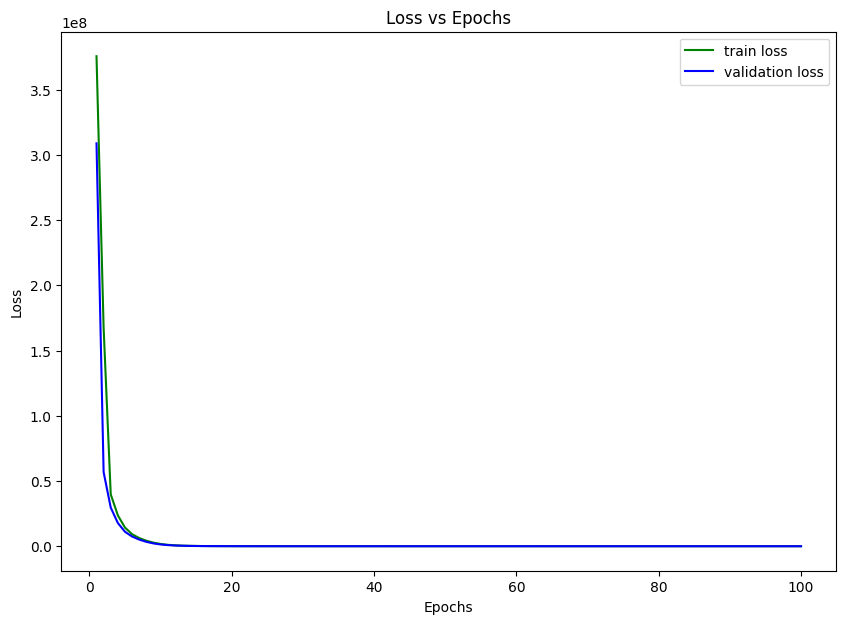

In [38]:
# grafico MSE vs epoca
plt.figure(figsize=(10, 7))
plt.plot(range(1,len(hist_loss2)+1), hist_loss2, color='green', linestyle='-', label='train loss')
plt.plot(range(1,len(hist_vloss2)+1), hist_vloss2, color='blue', linestyle='-', label='validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss vs Epochs')
plt.legend()
plt.show()

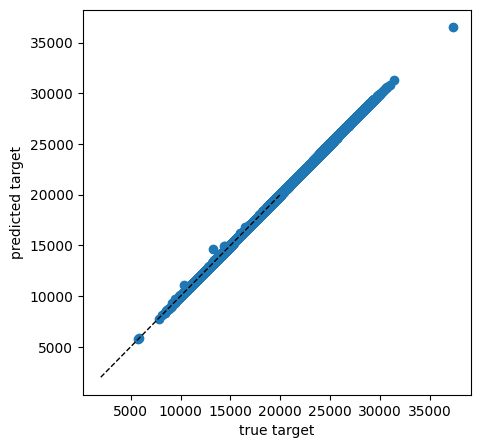

In [39]:
# plot predicted vs target

model2.eval()  # va sempre fatto per settare eventuali layer di droput e batch norm in evaluation model
model2.to('cpu')

loss = 0
metric = 0

true_target=torch.empty(0)
predicted_target=torch.empty(0)

with torch.no_grad():  # evita che vengano cacolati automaticamente i gradienti
  for xb, yb in dl_reg_test:
    pred = model2(xb)
    true_target = torch.cat((true_target, yb), dim=0)
    predicted_target = torch.cat((predicted_target, pred), dim=0)

tr = true_target.numpy()
pr = predicted_target.numpy()

#tr2 = tr[tr<20000]
#pr2 = pr[tr<20000]

tr2 = tr
pr2 = pr

plt.figure(figsize=(5,5))
plt.scatter(tr2, pr2)
plt.plot([2000,20000],[2000,20000], color='black', linewidth=1, linestyle='dashed')
plt.xlabel('true target')
plt.ylabel('predicted target')
plt.show()

# vediamo una buona predizione lineare